<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal 3
#### Fernando Coda
  
## Simulación de un ADC (cuantización) parte 1/2

En esta tarea simularemos el comportamiento de un ADC y cómo sus parámetros, tamaño de palabra de B bits y frecuencia de muestreo $f_s$ afectan a una señal (aproximadamente) analógica.

Para ello se puede analizar una **senoidal** con los siguientes parámetros:

- Frecuencia $f_0$ arbitraria, por ejemplo $f_0 = f_s / N = \Delta_f$
- **Amplitud normalizada**, es decir unitaria

**Se pide diseñar** un bloque cuantizador que opere sobre una señal discreta en tiempo $s_R$, de forma tal que para un ADC de $B$ bits y rango $±V_F$
, el operador

$$\large s_Q = \underset{B,V_f}{Q} \{ s_R \} $$

generará una $s_Q$ comprendida entre $±V_F$ y con valores discretos establecidos por el paso de cuantización $q = \frac{2 \cdot V_f}{2^{B-1}} \approx \frac{V_f}{2^{B-1}}$  $[Volts]$.

Visualice en una misma gráfica $s_R$ y $s_Q$, donde se pueda observar que tienen el mismo rango en Volts y el efecto de la cuantización para $V_F=2$ Volts y $B=4, 8,$ y $16$ bits.

---

Bonus:
- 🤯 Analizar la señal de error $e=s_Q−s_R$ verificando las descripciones estadísticas vistas en teoría (Distribución uniforme, media, varianza, incorrelación)

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from scipy      import signal as sig

def mi_funcion_sen(fs, ff, nn, vmax=1, dc=0, ph=0):
	end = nn / fs
	tt  = np.linspace(start=0, stop=end, num = nn, endpoint = False)
	xx  = vmax * np.sin(2. * np.pi * ff * tt + ph) + dc
	return tt,xx

def graficar_espectro(f, X_f, fs, *args, **kwargs):
	bfrec = f <= fs/2
	plt.plot(f[bfrec], 10 * np.log10(2*np.abs(X_f[bfrec])**2), *args, **kwargs)

def graficar_tiempo(t, x_t, *args, **kwargs):
	plt.plot(t, x_t, *args, **kwargs)
	plt.xlabel('t [s]'), plt.ylabel('Amplitud [V]')

In [17]:
###############################################################################
# Parámetros de mi señal
fx = 2000 #fs/N # Hz
Ax = 1.0 # Volts
offset = 0 # Volts
phase = 0

# Parámetros de la simulación
fs = 48000 # Hz
N  = fs  # n° de muestras
Ts = 1 / fs # segundos
T_simulacion = N * Ts # segundos

# Genero mi señal senoidal con los parámetros anteriores
t, x_t  = mi_funcion_sen(fs, fx, N, Ax, offset, phase)

SNR_dB = 20 # signal to noise ratio, valor deseado
variance_noise  = 10 ** (SNR_dB / (-10))

# Ruido de amplificacion: ruido analogico, distribucion normal
noise_analog = np.random.normal(loc=0.0, scale=np.sqrt(variance_noise), size=N)
s_R = x_t + noise_analog


###############################################################################
## ADC
Vf = 2.0

# Normalizo la señal. Obtengo su valor pico a pico
Vpp = np.ptp(s_R)

# Valor de escala deseado: 90% de Vf
k_load = 0.9
k = k_load * (2*Vf) / Vpp

# Escalo mi señal a +- 90% de Vf 
s_R *= k
# Saturo a ±Vf
np.clip(s_R, -Vf, Vf, out=s_R);

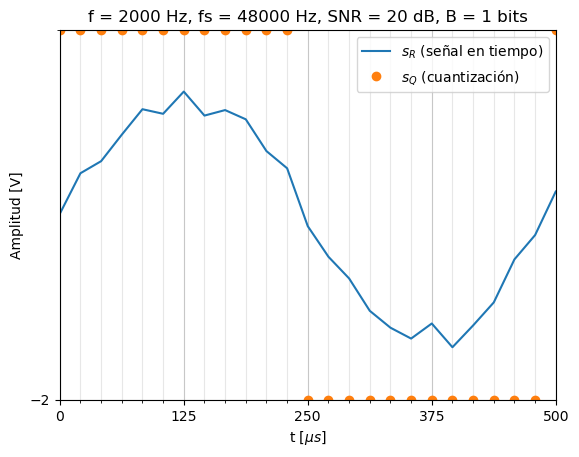

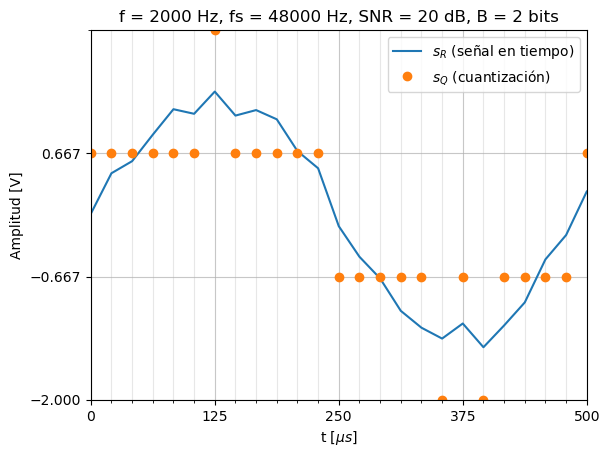

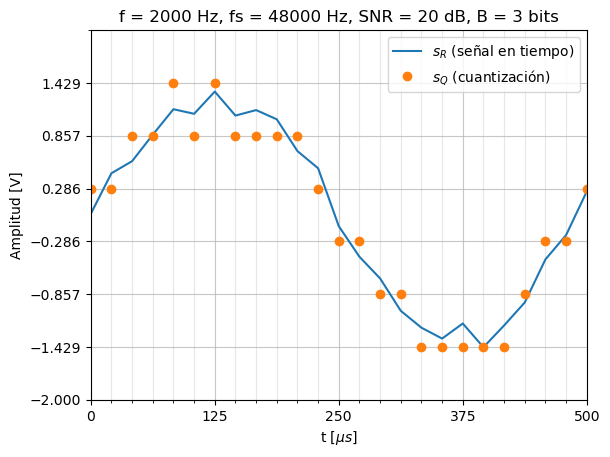

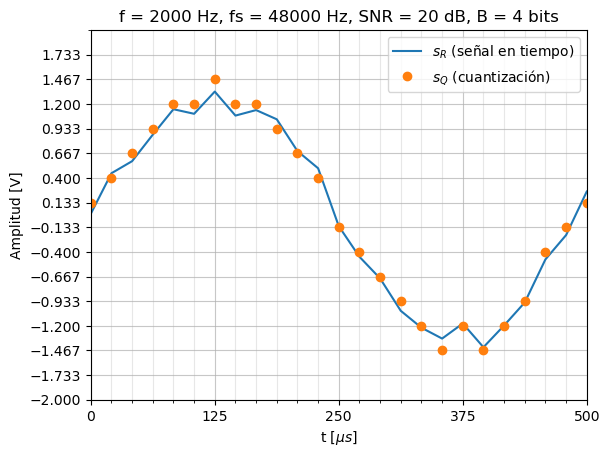

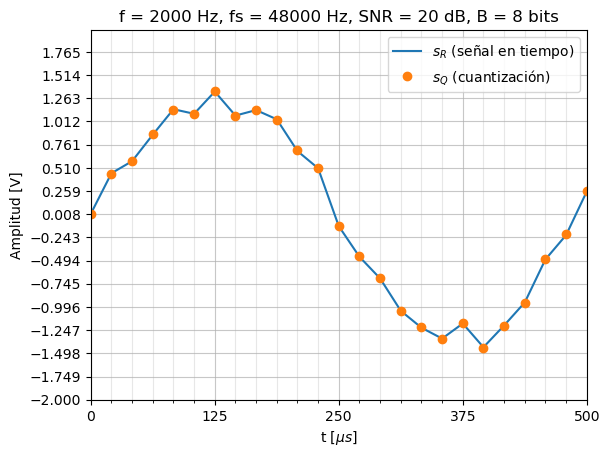

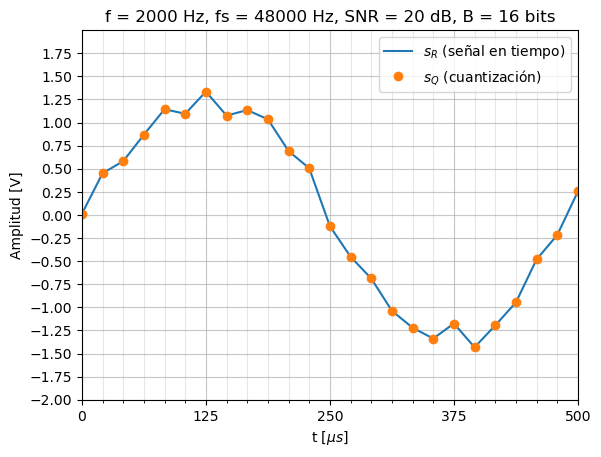

In [18]:
q = np.zeros(17)
s_Q = np.zeros((17, N))
B_bits = [1, 2, 3, 4, 8, 16]

for B in B_bits:

    q[B] = (2*Vf) / (2**B - 1)

    ###########################################################################
    ## Cuantización de la señal
    s_Q[B] = np.floor(s_R / q[B]) * q[B] + q[B]/2


    ###########################################################################
    ## Gráficos

    fig = plt.figure(B)
    fig.clf()

    ax = fig.add_subplot()

    plt.title('f = ' + str(fx) + ' Hz, fs = ' + str(fs) + ' Hz' + \
              ', SNR = ' + str(SNR_dB) + ' dB, B = ' + str(B) + ' bits')
    plt.xlabel('t [$\mu s$]'), plt.ylabel('Amplitud [V]')

    yticks_major_q = q[B]
    while yticks_major_q < Vf/8: 
        yticks_major_q *= 2
    
    ax.set_yticks(np.arange(-Vf, Vf, yticks_major_q), minor=False)
    if B < 8:
        ax.set_yticks(np.arange(-Vf, Vf+q[B], q[B]), minor=True)

    ax.set_xticks(np.linspace(0, 1/fx, fs//fx//5 + 1), minor=False)
    ax.set_xticks(np.linspace(0, 1/fx, fs//fx    + 1), minor=True)
    ax.set_xticklabels( (ax.get_xticks() * 10**6).astype(int) )

    ax.set_xlim([0, 1/fx])
    ax.set_ylim([-Vf, Vf])

    ax.grid(which='major', alpha=0.7)
    ax.grid(which='minor', alpha=0.3)

    ax.plot(t, s_R,        label='$s_{R}$ (señal en tiempo)')
    ax.plot(t, s_Q[B],'o', label='$s_{Q}$ (cuantización)')

    ax.legend()
    plt.show()


Observamos cómo a medida que incrementamos el número de bits, la representación cuantizada es más fiel a lo que presenta la señal original.

---

Bonus:
- 🤯 Analizar la señal de error $e=s_Q−s_R$ verificando las descripciones estadísticas vistas en teoría (Distribución uniforme, media, varianza, incorrelación)

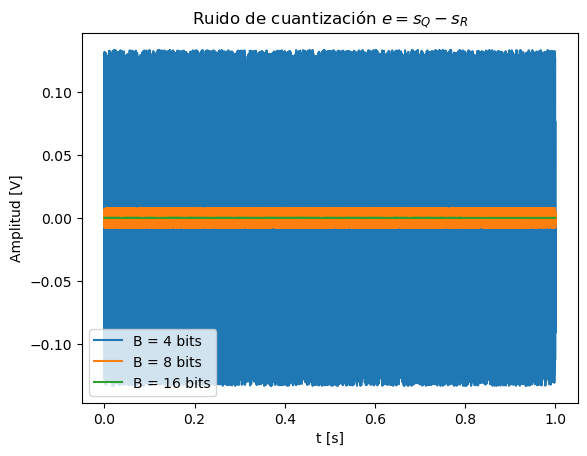

In [19]:
nq = np.zeros((17, N))

ax1 = plt.figure(1).add_subplot()
plt.title('Ruido de cuantización $e = s_Q - s_R$')
plt.xlabel('t [s]'), plt.ylabel('Amplitud [V]')

# Grafico en el tiempo los distintos ruidos de cuantización
for B in [4, 8, 16]:
    # Señal de ruido (quantization noise)
    nq[B] = s_Q[B] - s_R
    np_mean = np.mean(nq)

    ax1.plot(t, nq[B], label='B = '+str(B)+' bits')
    
ax1.legend()
plt.show()

A medida que se incrementa el número de bits, el ruido de cuantización disminuye.

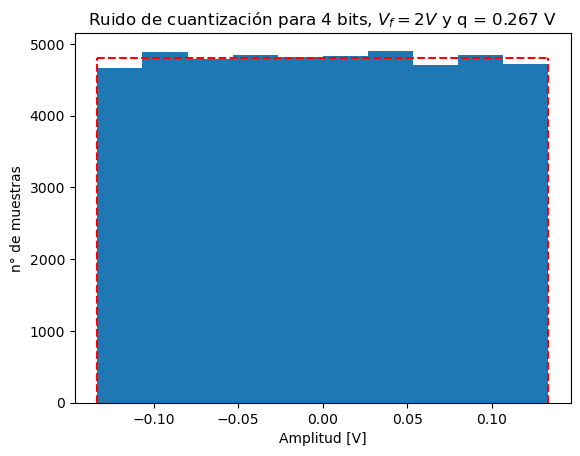

In [20]:
from matplotlib.lines import Line2D

# Analizo ahora solo para el caso de 4 bits

ax2 = plt.figure().add_subplot()

plt.title('Ruido de cuantización para 4 bits, $V_f=2V$ y q = ' + f'{q[4]:.3f}' + ' V')
plt.xlabel('Amplitud [V]'), plt.ylabel('n° de muestras')

ax2.hist(nq[4])

line = Line2D([-q[4]/2,  q[4]/2], [N/10,N/10], linestyle='--', color='r')
ax2.add_line(line)

line = Line2D([-q[4]/2, -q[4]/2], [0,   N/10], linestyle='--', color='r')
ax2.add_line(line)

line = Line2D([ q[4]/2,  q[4]/2], [0,   N/10], linestyle='--', color='r')
ax2.add_line(line)

plt.show()


Se verifica la distribución uniforme del ruido de cuantización entre -q/2 y q/2